In [202]:
import pandas as pd
import numpy as np

df = pd.read_csv('churn.csv')
col_names = df.columns.tolist()
print(col_names)

['Account Length', 'VMail Message', 'Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins', 'CustServ Calls', 'Churn', "Int'l Plan", 'VMail Plan', 'Day Calls', 'Day Charge', 'Eve Calls', 'Eve Charge', 'Night Calls', 'Night Charge', 'Intl Calls', 'Intl Charge', 'State', 'Area Code', 'Phone']


In [192]:
# define features and labels
y = df['Churn']
to_drop = ['State','Area Code','Phone','Churn']
X = df.drop(to_drop,axis=1)

In [193]:
#feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [194]:
print("Features has %d observations and %d variables" % X.shape)
print("Unique target labels:", np.unique(y))

Features has 3333 observations and 17 variables
Unique target labels: [0 1]


In [195]:
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

算法 MLP 平均准确率: 94.089% 标准差: 0.014
算法 RF 平均准确率: 94.449% 标准差: 0.014
算法 GB 平均准确率: 95.260% 标准差: 0.012
算法 XGB 平均准确率: 95.290% 标准差: 0.011


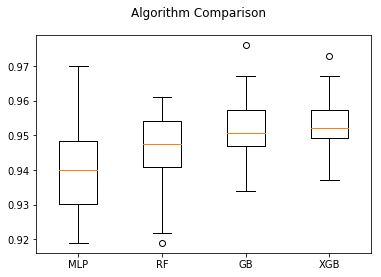

In [196]:
# prepare configuration for cross validation test harness
seed = 17
# prepare models
models = []
models.append(('MLP', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 8), random_state=1)))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('XGB', XGBClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "算法 %s 平均准确率: %.3f%% 标准差: %.3f" % (name, cv_results.mean()*100., cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [197]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import itertools

In [198]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2798   52]
 [ 153  330]]
Normalized confusion matrix
[[ 0.98175439  0.01824561]
 [ 0.31677019  0.68322981]]
Confusion matrix, without normalization
[[2825   25]
 [ 152  331]]
Normalized confusion matrix
[[ 0.99122807  0.00877193]
 [ 0.31469979  0.68530021]]
Confusion matrix, without normalization
[[2814   36]
 [ 129  354]]
Normalized confusion matrix
[[ 0.98736842  0.01263158]
 [ 0.26708075  0.73291925]]
Confusion matrix, without normalization
[[2824   26]
 [ 136  347]]
Normalized confusion matrix
[[ 0.99087719  0.00912281]
 [ 0.2815735   0.7184265 ]]


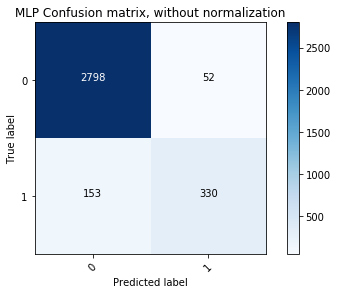

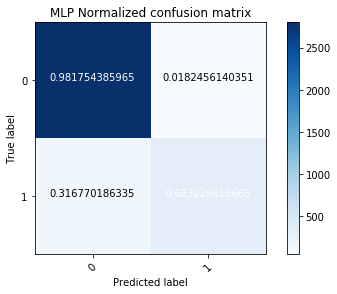

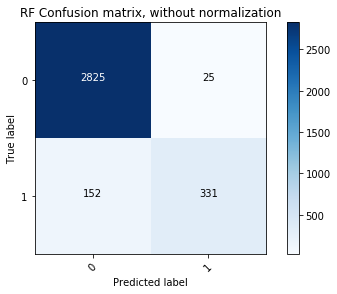

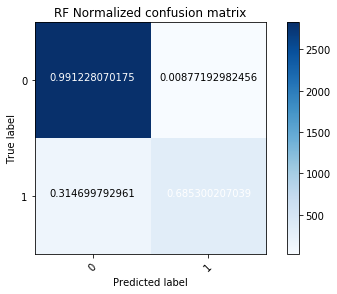

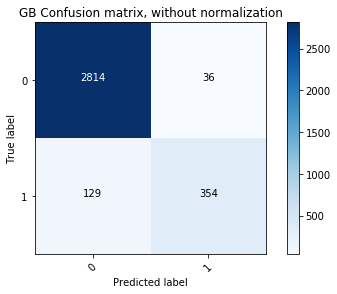

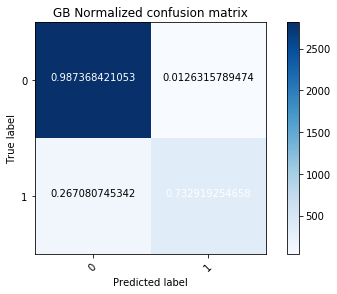

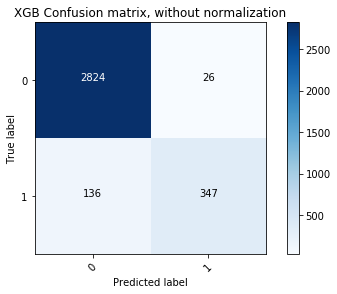

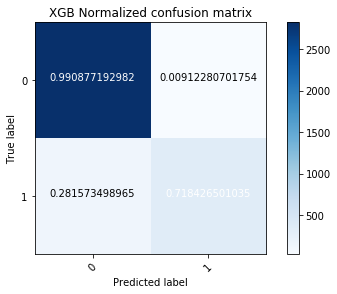

In [199]:
#compare confusion matrix
y = np.array(y)
class_names = np.unique(y)

for name, model in models:
    y_pred = cross_val_predict(model,X,y,cv=10)
    conf_mat = confusion_matrix(y,y_pred)    
    
    plt.figure()
    plot_confusion_matrix(conf_mat, classes=class_names,
                      title='{} Confusion matrix, without normalization'.format(name))
    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title= '{} Normalized confusion matrix'.format(name))

    #plt.show()

In [200]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

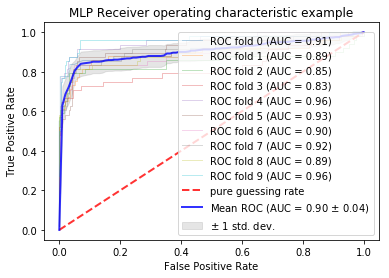

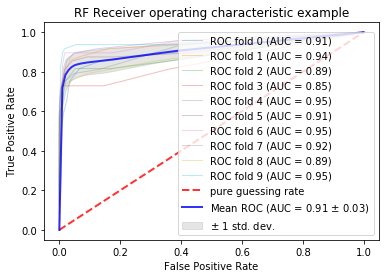

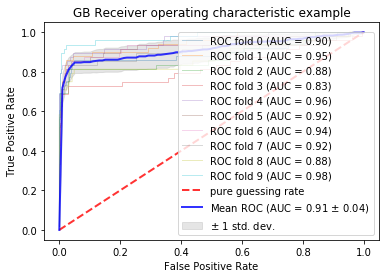

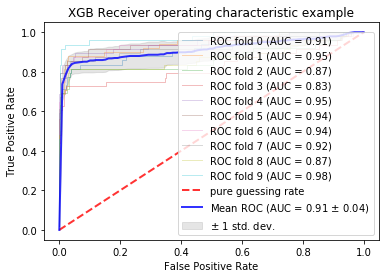

In [201]:
# compare ROC AUC

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
for name, model in models:
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='pure guessing rate', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Receiver operating characteristic example'.format(name))
    plt.legend(loc="lower right")
    plt.show()